In [1]:
# !wget https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen2-Audio/audio/guess_age_gender.wav
# !wget https://huggingface.co/datasets/mesolitica/Malaysian-SFT/resolve/main/combine/combined-malaysian-sft-20k-sample.jsonl

In [2]:
import os

os.environ['HF_HOME'] = '/home/husein/ssd3'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [11]:
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from datasets import Audio
from peft import LoraConfig, get_peft_model
from transformers import AutoProcessor, Qwen2AudioForConditionalGeneration, AutoConfig, AutoModelForCausalLM
from streaming import MDSWriter
from streaming.base.format.mds.encodings import Encoding, _encodings
from streaming import LocalDataset
import streaming
import numpy as np
from tqdm import tqdm
from glob import glob
import os
import json

class UInt32(Encoding):
    def encode(self, obj) -> bytes:
        return obj.tobytes()

    def decode(self, data: bytes):
        return np.frombuffer(data, np.uint32)

_encodings['uint32'] = UInt32

columns = {
    'input_ids': 'uint32',
    'position_ids': 'uint32',
    'attention_mask': 'uint32',
    'audio': 'str',
    'text': 'str'
}
hashes = 'sha1', 'xxh64'

In [4]:
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-Audio-7B-Instruct")
audio_token = "<|AUDIO|>"
audio_bos_token = "<|audio_bos|>"
audio_eos_token = "<|audio_eos|>"
audio_token_id = processor.tokenizer._convert_token_to_id_with_added_voc('<|AUDIO|>')
pad_token_id = processor.tokenizer.pad_token_id
tokenizer = processor.tokenizer
torch_dtype = torch.bfloat16
min_dtype = torch.finfo(torch_dtype).min
sequence_length = 4096

In [15]:
def block_diagonal_concat_inverted(*masks, dtype=torch.bfloat16):
    total_size = sum(mask.size(0) for mask in masks)
    combined_mask = torch.zeros(total_size, total_size, dtype=dtype)

    current_pos = 0

    for mask in masks:
        size = mask.size(0)
        combined_mask[current_pos:current_pos + size, current_pos:current_pos + size] = mask
        current_pos += size

    min_value = torch.finfo(dtype).min if dtype.is_floating_point else torch.iinfo(dtype).min
    inverted_mask = torch.where(combined_mask == 1, torch.tensor(0, dtype=dtype), min_value)
    return inverted_mask.unsqueeze(0)

def pad_attention_mask_4d(attention_mask, max_size = 4096, value = 0.0):
    maxlen_right = max_size
    maxlen_bottom = max_size
    attention_mask = [
        F.pad(
            attention_mask[i],
            (0, maxlen_right - attention_mask[i].shape[-2], 0, maxlen_bottom - attention_mask[i].shape[-1]), value = value) for i in range(
            len(attention_mask))]
    return torch.stack(attention_mask)

In [16]:
class DatasetFixed(torch.utils.data.Dataset):
    def __init__(self, local):
        self.dataset = LocalDataset(local=local)
        self.audio = Audio(sampling_rate=16000)

    def __getitem__(self, idx):
        data = self.dataset[idx]
        try:
            data.pop('text', None)
            audio_files = data.pop('audio', '')
            data['labels'] = data["input_ids"].copy()
            masking = data.pop('attention_mask')

            data.pop('token_type_ids', None)
            for k in data.keys():
                data[k] = torch.tensor(data[k].astype(np.int64))

            masks = []
            for m in masking:
                masks.append(torch.tril(torch.ones(m, m)))
            attention_mask = block_diagonal_concat_inverted(*masks)
            data['attention_mask'] = attention_mask

            data['labels'][data['labels'] == audio_token_id] = -100
            data['labels'][data['labels'] == pad_token_id] = -100

            if len(audio_files):
                files = json.loads(audio_files)
                audios = []
                for f in files:
                    audio = self.audio.decode_example(
                    self.audio.encode_example(f))['array']
                    audios.append(audio)

                inputs_audio = processor.feature_extractor(
                    audios, return_attention_mask=True, 
                    sampling_rate=16000,
                    padding="max_length", return_tensors = 'pt')

                data['input_features'] = inputs_audio['input_features']
                data['feature_attention_mask'] = inputs_audio['attention_mask']

            return data

        except Exception as e:
            print('Exception', e)
            return None

    def __len__(self):
        return len(self.dataset)

def collator(batch):
    batch = [b for b in batch if b is not None] 
    input_ids, attention_mask, position_ids, labels = [], [], [], []
    input_features, feature_attention_mask = [], []

    for b in batch:
        if 'input_features' in b:
            input_features.append(b['input_features'])
            feature_attention_mask.append(b['feature_attention_mask'])
        input_ids.append(b['input_ids'][None])
        attention_mask.append(b['attention_mask'])
        position_ids.append(b['position_ids'][None])
        labels.append(b['labels'][None])

    input_ids = {
        'input_ids': torch.concat(input_ids, 0),
        'attention_mask': pad_attention_mask_4d(attention_mask, sequence_length, min_dtype),
        'position_ids': torch.concat(position_ids, 0),
        'labels': torch.concat(labels, 0),
    }
    if len(input_features):
        input_ids['input_features'] = torch.concat(input_features, 0)
        input_ids['feature_attention_mask'] = torch.concat(feature_attention_mask, 0)

    return input_ids

In [17]:
dataset = DatasetFixed('packing-4k')

In [23]:
attention_mask = collator([dataset[1], dataset[0]])['attention_mask']
attention_mask.shape

torch.Size([2, 1, 4096, 4096])

In [28]:
attention_mask[0, 0].float().numpy()

array([[ 0.0000000e+00, -3.3895314e+38, -3.3895314e+38, ...,
        -3.3895314e+38, -3.3895314e+38, -3.3895314e+38],
       [ 0.0000000e+00,  0.0000000e+00, -3.3895314e+38, ...,
        -3.3895314e+38, -3.3895314e+38, -3.3895314e+38],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -3.3895314e+38, -3.3895314e+38, -3.3895314e+38],
       ...,
       [-3.3895314e+38, -3.3895314e+38, -3.3895314e+38, ...,
        -3.3895314e+38, -3.3895314e+38, -3.3895314e+38],
       [-3.3895314e+38, -3.3895314e+38, -3.3895314e+38, ...,
        -3.3895314e+38, -3.3895314e+38, -3.3895314e+38],
       [-3.3895314e+38, -3.3895314e+38, -3.3895314e+38, ...,
        -3.3895314e+38, -3.3895314e+38, -3.3895314e+38]], dtype=float32)

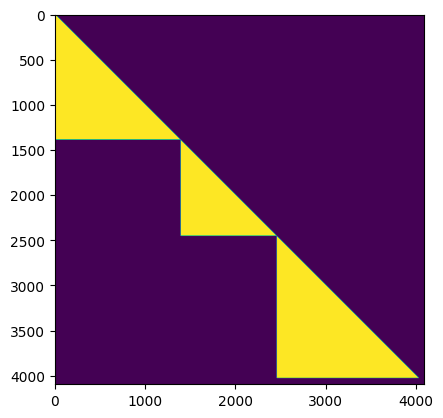

In [29]:
import matplotlib.pyplot as plt

plt.imshow(attention_mask[0, 0].float().numpy())

In [30]:
class Model(Qwen2AudioForConditionalGeneration):
    def __init__(self, config):
        super().__init__(config)
        
    def forward(self, input_ids, attention_mask, position_ids, input_features, feature_attention_mask, labels = None, **kwargs):
        super_out = super().forward(
            input_ids = input_ids, 
            attention_mask = attention_mask, 
            position_ids = position_ids,
            input_features = input_features, 
            feature_attention_mask = feature_attention_mask,
            
        )
        if labels is not None:
            logits = super_out.logits
            vocab_size = logits.shape[-1]
            logits = logits.float()
            labels = labels.to(logits.device)
            labels = nn.functional.pad(labels, (0, 1), value=-100)
            shift_labels = labels[..., 1:].contiguous()
            logits = logits.view(-1, vocab_size)
            shift_labels = shift_labels.view(-1)
            shift_labels = shift_labels.to(logits.device)
            loss = nn.functional.cross_entropy(logits, shift_labels, ignore_index=-100, reduction='mean')
            return {'loss': loss}

In [31]:
model = Model.from_pretrained(
    "Qwen/Qwen2-Audio-7B-Instruct", torch_dtype = torch.bfloat16)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [32]:
selected = ["q_proj", "k_proj", "v_proj", "o_proj",
                  "gate_proj", "up_proj", "down_proj", "embed_tokens", "lm_head"]

In [33]:
target_modules = []
for id, (name, param) in enumerate(model.named_modules()):
    if 'language_model.model' in name and any([s in name for s in selected]):
        target_modules.append(name)
if 'lm_head' in selected:
    target_modules.append('language_model.lm_head')

In [34]:
peft_config = LoraConfig(
    lora_alpha=128,
    lora_dropout=0.0,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=target_modules
)

In [35]:
model = get_peft_model(model, peft_config)

In [36]:
_ = model.cuda()

In [39]:
torch.cuda.empty_cache()

In [42]:
# with torch.no_grad():
#     batch = [dataset[1]]
#     o = collator(batch)
#     for k in o.keys():
#         o[k] = o[k].cuda()
#     o = model(**o)

In [43]:
# o

In [31]:
o

{'loss': tensor(5.0512, device='cuda:0')}